In [35]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from typing import List
import numpy as np
import joblib
from pprint import pprint
from math import ceil
import imodelsx.util
import sasc.viz
import pickle as pkl
import json
from copy import deepcopy
from numpy.linalg import norm
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import normalize

from PIL import Image
import img2pdf
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from typing import List
import numpy as np
from copy import deepcopy
import joblib
from pprint import pprint
from math import ceil
import cortex
from neuro.config import repo_dir, PROCESSED_DIR, setup_freesurfer
from collections import defaultdict
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import gemv
from neuro.flatmaps_helper import load_flatmaps
import sasc.viz
from neuro import analyze_helper
import nibabel as nib
neurosynth_compare = __import__('04_neurosynth_compare')
import neurosynth
from neuro.features.questions.gpt4 import QS_35_STABLE
import viz
setup_freesurfer()
from sasc.config import CACHE_DIR, RESULTS_DIR, cache_ngrams_dir, regions_idxs_dir, FMRI_DIR, SAVE_DIR_FMRI
import sasc.modules.fmri_module
from imodels import StableClustering


def _get_35q_weights(subject):
    d = defaultdict(list)
    setting = 'individual_gpt4_ndel=1_pc_new'
    flatmaps_qa_dict = joblib.load(
            join(PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
    flatmaps_qa_list = [
        flatmaps_qa_dict[q] for q in QS_35_STABLE
    ]
    weights_arr_to_cluster = np.vstack(flatmaps_qa_list)
    return weights_arr_to_cluster

def _get_llama_weights(subject):
    mod = sasc.modules.fmri_module.fMRIModule(
        subject=f"UT{subject}",
        # checkpoint="facebook/opt-30b",
        checkpoint="huggyllama/llama-30b",
        init_model=False,
        restrict_weights=False,
    )
    weights_arr_full = mod.weights
    # weights_arr_full has shape (num_delays x num_linear_coefs, num_voxels)
    weights_arr_to_cluster = weights_arr_full.reshape(
        4, -1, weights_arr_full.shape[1]).mean(axis=0)
    return weights_arr_to_cluster

subject = 'S02'
# setting = 'llama'
setting = '35q'
sparse = '' # '_sparse'

if setting == 'llama':
    weights_arr_to_cluster = _get_llama_weights(subject)
elif setting == '35q':
    weights_arr_to_cluster = _get_35q_weights(subject)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# pca
num_pcs = 4
if sparse == '':
    pca = PCA(n_components=num_pcs, whiten=True)
elif sparse == '_sparse':
    pca = PCA(n_components=num_pcs, whiten=True, svd_solver='sparse')

X = weights_arr_to_cluster.T
X_normalized = normalize(X)
pca.fit(X_normalized)
# pca.components_.shape is (num_pcs, num_linear_coefs)

pc_coefs_per_voxel = pca.transform(X_normalized)
# pc_coefs_per_voxel.shape is (num_voxels, num_pcs)

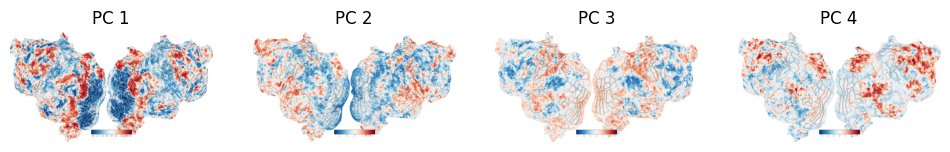

In [ ]:
# run pca
for i in range(num_pcs):
    flatmap = pc_coefs_per_voxel[:, i]
    sasc.viz._save_flatmap(
        flatmap, 'S02', fname_save=f'pca/pca_{i+1}.png')

# read all plots and save as subplots on the same page
fig, axs = plt.subplots(1, 4, figsize=(12, 5))
axs = axs.ravel()
for i in range(num_pcs):
    axs[i].imshow(Image.open(f'pca/pca_{i+1}.png'))
    axs[i].axis('off')
    axs[i].set_title(f'PC {i + 1}')
plt.tight_layout()

joblib.dump(pc_coefs_per_voxel, f'pca/pca{sparse}_{setting}_coefs.pkl')
plt.savefig(f'pca/pca{sparse}_subplots_{setting}.png')

# 3d colormaps

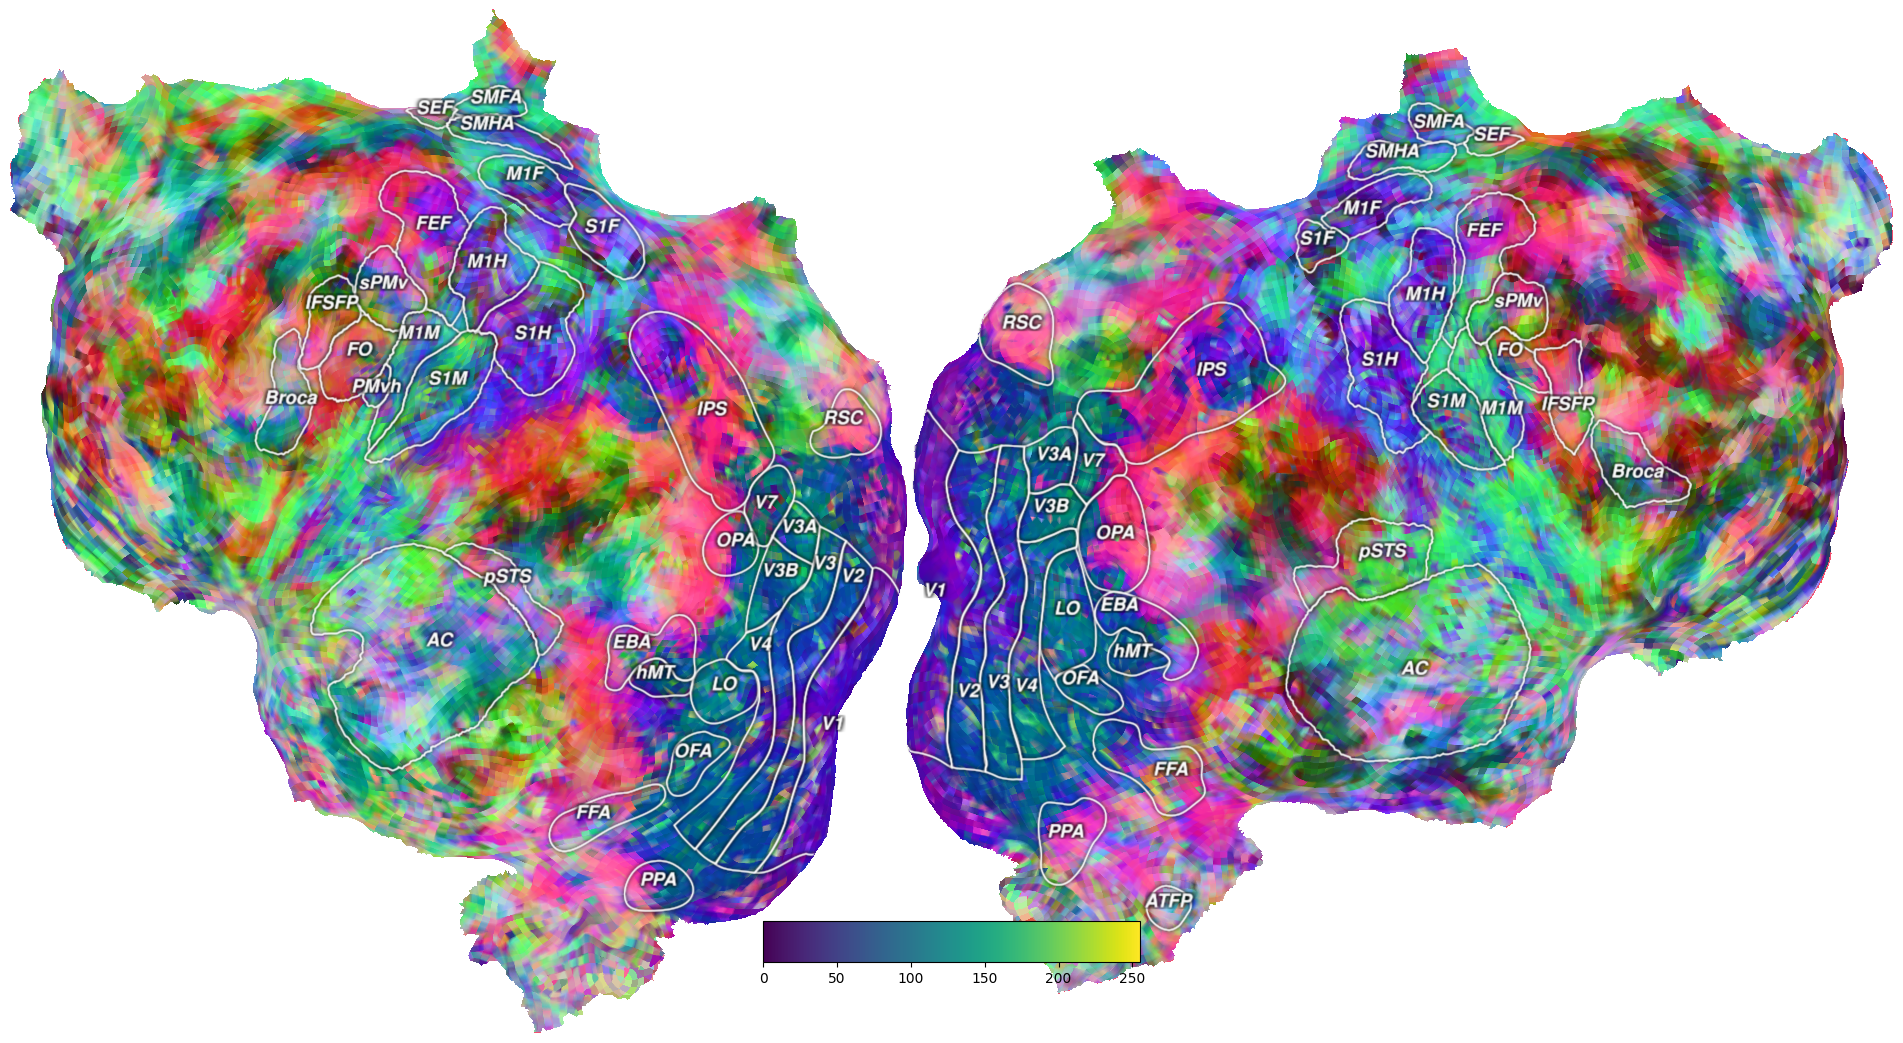

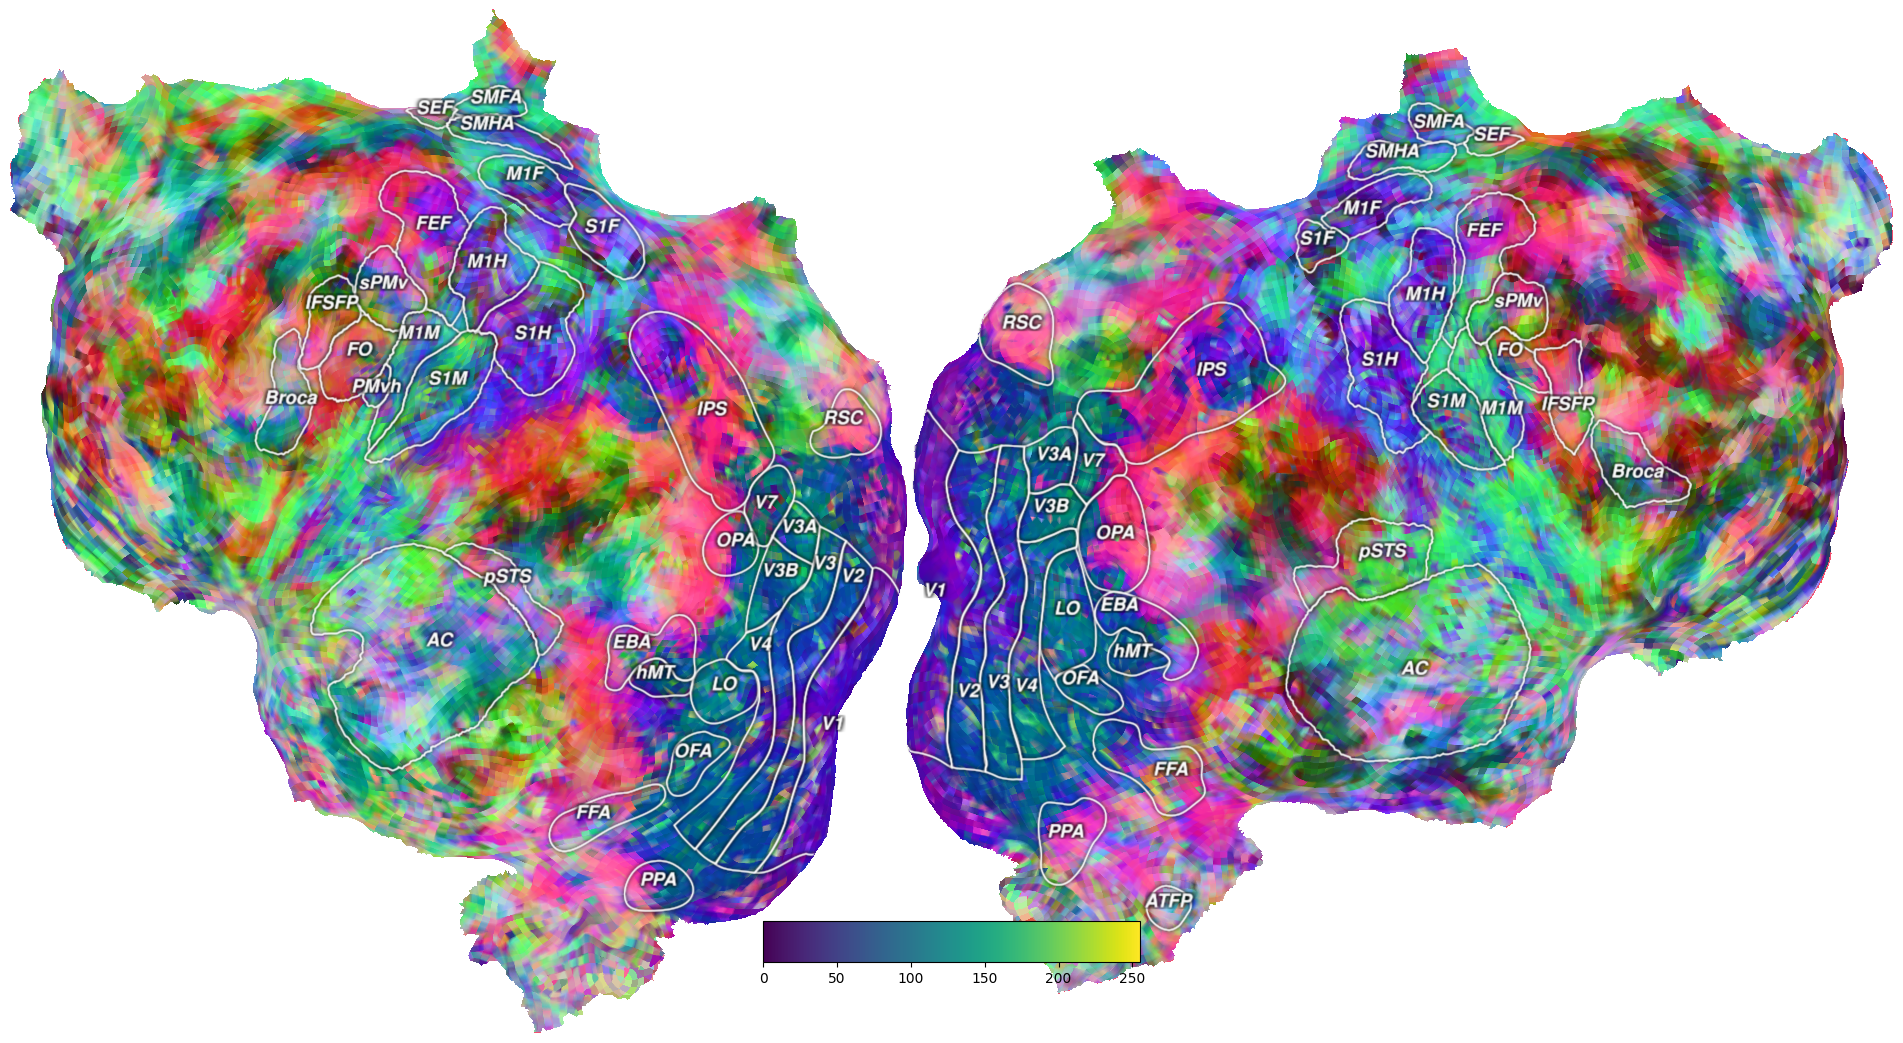

In [22]:
import cortex
import numpy as np

# Load a sample subject
subject = "UTS02"  # Change this to your actual subject ID
xfmname = "UTS02_auto"  # Change based on your transformation

# Generate three example maps (replace with real data)
volume_shape = flatmap.shape
map1 = pc_coefs_per_voxel[:, 0]
map2 = pc_coefs_per_voxel[:, 1]
map3 = pc_coefs_per_voxel[:, 2]

# Normalize each map to be in range [0,1]
map1 = (map1 - map1.min()) / (map1.max() - map1.min())
map2 = (map2 - map2.min()) / (map2.max() - map2.min())
map3 = (map3 - map3.min()) / (map3.max() - map3.min())

# Create a 3-channel RGB volume
rgb_volume = cortex.VolumeRGB(
    map1, map2, map3, subject=subject, xfmname=xfmname)

# Show the visualization
cortex.quickshow(rgb_volume)